In [ ]:
"""
author: Vetivert? 💐 
created: 14/04/2025 @ 15:26:37
"""

import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
import seaborn as sns # type: ignore

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold # type: ignore
from sklearn.preprocessing import StandardScaler, label_binarize # type: ignore
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc # type: ignore
from sklearn.ensemble import RandomForestClassifier # type: ignore

import sys
import os

current_dir = os.path.abspath('')

parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from src.utils.prefix_path import *


In [51]:
# Load dataset
df = pd.read_csv(FULL_DATA_PATH, sep=";", header=3) #separator is ;
# df = df.apply(pd.to_numeric, errors='coerce')

# Drop redundant cols + rows
df.drop(REDUNDANT_ROWS, inplace=True) #indexes of 2019 data 
df.index = range(len(df)) #reset index
df.drop(REDUNDANT_COLS, axis=1, inplace=True)

df.fillna(FILLNA_VALUES) #df[1] = df[1].fillna(0)
df['Other'] = pd.to_numeric(df['Other'], errors='coerce').fillna(1) #addtional diseases
df.iloc[np.where(df == '8(nặng xin về)')] = 8

for i in HEART_INDEX:
    df[i] = pd.to_numeric(df[i], errors='coerce')
    print(f"{i}: {df[str(i)].mean()}")
print("\nDiastolic BP < 80: Huyết áp tối ưu \nSystolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp")

# df.drop(HEART_INDEX, axis=1, inplace=True)

uniques, counts = np.unique(df['Diagnosis'], return_counts=True)
print('\nDiagnosis\'s classes: ',dict(zip(uniques, np.round(counts * 100 / len(df['Diagnosis']), 2))))
df['Diagnosis'] = np.where(df['Diagnosis'] == '3', '2', df['Diagnosis'])
df['Day of illness'] = np.where(df['Day of illness'] == '55', '5', df['Day of illness'])
df['Systolic BP'] = np.where(df['Systolic BP'] == '1120', '120', df['Systolic BP'])


# hematoma group
hema = df[HEMATOMA_COLS]
hema = hema.assign(stacked=hema.astype(str).agg(''.join, axis=1))
hema
hema['stacked'] = (pd.to_numeric(hema['stacked'], errors='coerce'))
hema['stacked_int'] = np.where(hema['stacked'] == 0, 0, 1)

df.insert(df.columns.get_loc(HEMATOMA_COLS[0]), 'hematoma', hema['stacked_int']) #get col index by its name
df.drop(HEMATOMA_COLS, axis=1, inplace=True)

# bleeding group
bleed = df[BLEEDING_COLS]
bleed = bleed.assign(stacked=bleed.astype(str).agg(''.join, axis=1))
bleed['stacked'] = (pd.to_numeric(bleed['stacked'], errors='coerce'))
bleed['stacked_int'] = np.where(bleed['stacked'] == 0, 0, 1)

df.insert(df.columns.get_loc(BLEEDING_COLS[0]), 'Mucosa membrane bleeding', bleed['stacked_int'])
df.drop(BLEEDING_COLS, axis=1, inplace=True)

# additional diseases group
add_diseases = df[ADDITIONAL_DISEASES]
add_diseases = add_diseases.assign(stacked=add_diseases.astype(str).agg(''.join, axis=1))
add_diseases['stacked'] = (pd.to_numeric(add_diseases['stacked'], errors='coerce'))
add_diseases['stacked_int'] = np.where(add_diseases['stacked'] == 0, 0, 1)

df.insert(df.columns.get_loc(ADDITIONAL_DISEASES[0]), 'additional_diseases', add_diseases['stacked_int'])
df.drop(ADDITIONAL_DISEASES, axis=1, inplace=True)


Pulse rate: 89.60148514851485
Systolic BP: 117.25
Diastolic BP: 70.63861386138613

Diastolic BP < 80: Huyết áp tối ưu 
Systolic BP <= 130: Huyết áp bình thường, 130<x<140: Tiền tăng huyết áp

Diagnosis's classes:  {'1': 56.27, '2': 39.8, '3': 3.93}


In [38]:
df.loc[:, :'Oliguria'].isnull().sum() #check missing values

Diagnosis                       0
Gende                           0
DHF infection His.              4
additional_diseases             0
Fever                           2
Bleeding                        2
Fatigue                         2
Day of illness                  3
Level of temp                 184
Duration fever                192
Headache                        2
Body ache                       2
Rash                            2
hematoma                        0
Mucosa membrane bleeding        0
Pleural effusion                2
Ascites                         2
Pericardial effusion            2
Vomiting                        3
Abdominal pain or tendness      3
Liver enlargement               3
Oliguria                        5
dtype: int64

## STRATEGY 1: should we keep MISSING_2017 based on 2019 dataset

x1_train shape:  (148, 24) y1_train shape:  (148,)
x1_test shape:  (37, 24) y1_test shape:  (37,)
percentage of classes:  {'1': 45.95, '2': 54.05}
Accuracy: 0.68
percentage of predictions:  {'1': 56.76, '2': 43.24}


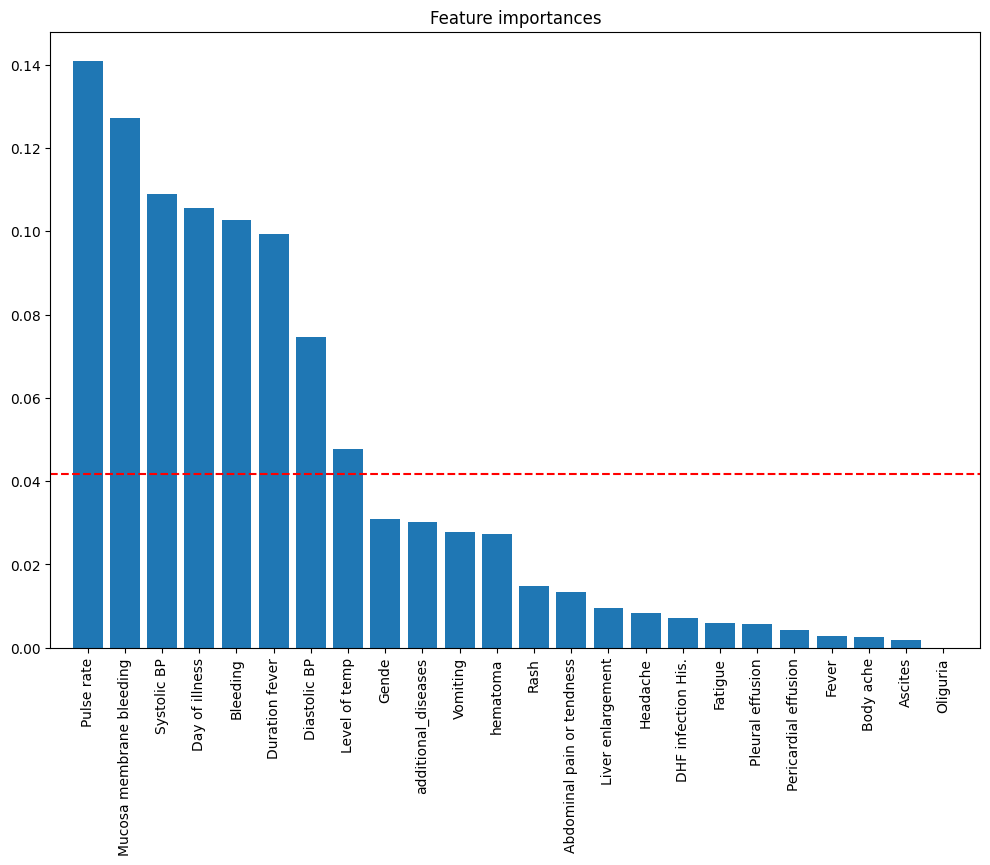

In [12]:
# strategy 1, 20% test_set = 0.2 * range(line 0, line 221) + 0.2 * range(line 222, line 407)
df_set = df.loc[222:, :'Oliguria'].copy().fillna(0)

x1_train, x1_test, y1_train, y1_test = train_test_split(df_set.drop(columns=['Diagnosis']), df_set['Diagnosis'], \
                                                    test_size=0.2, random_state=None, stratify=df_set['Diagnosis'])
print('x1_train shape: ', x1_train.shape, 'y1_train shape: ',  y1_train.shape)
print('x1_test shape: ', x1_test.shape, 'y1_test shape: ',  y1_test.shape)
uniques, counts = np.unique(y1_test, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y1_test), 2))))

rf_1 = RandomForestClassifier(n_estimators=100, random_state=None)
rf_1.fit(x1_train, y1_train)

y1_pred = rf_1.predict(x1_test)
accuracy = accuracy_score(y1_test, y1_pred)
print(f"Accuracy: {accuracy:.2f}")
# print(classification_report(y1_test, y1_pred))

uniques, counts = np.unique(y1_pred, return_counts=True)
print('percentage of predictions: ',dict(zip(uniques, np.round(counts * 100 / len(y1_pred), 2))))

# Plotting feature importances
importances = rf_1.feature_importances_
indices = np.argsort(importances)[::-1]
features = x1_train.columns
plt.figure(figsize=(12, 8))
plt.title("Feature importances")
plt.bar(range(x1_train.shape[1]), importances[indices], align="center")
plt.xticks(range(x1_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, x1_train.shape[1]])
plt.axhline(y=importances.mean(), color='r', linestyle='--')
plt.show()

### strategy 2, without HEART_INDEX

In [ ]:
# df.drop(HEART_INDEX, axis=1, inplace=True)

x2_train shape:  (148, 24) y2_train shape:  (148,)
x2_test shape:  (37, 24) y2_test shape:  (37,)
percentage of classes:  {'1': 45.95, '2': 54.05}
Accuracy: 0.62
percentage of predictions:  {'1': 51.35, '2': 48.65}


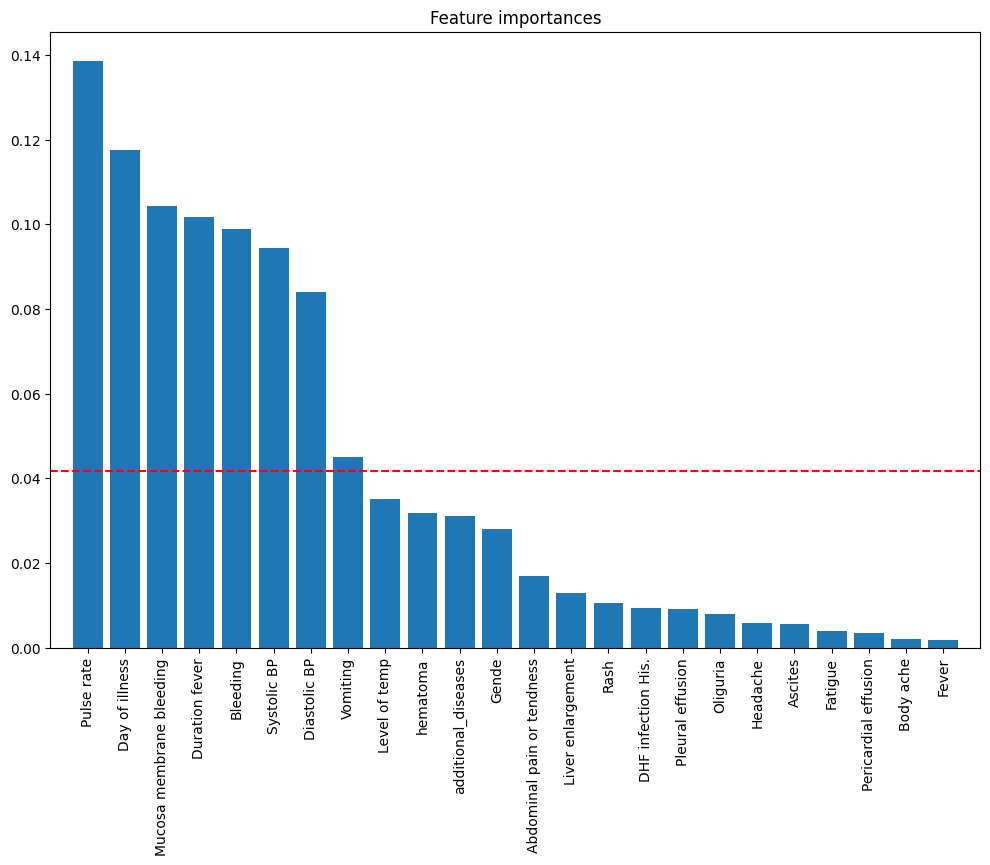

In [52]:
df_set2 = df.loc[222:, :'Oliguria'].copy()
for col in MISSING_2017:
    df_set2[col] = pd.to_numeric(df_set2[col], errors='coerce')
    df_set2.fillna(df_set2[col].mean(), inplace=True)
df_set2.fillna(0, inplace=True)

x2_train, x2_test, y2_train, y2_test = train_test_split(df_set2.drop(columns=['Diagnosis']), df_set2['Diagnosis'], \
                                                    test_size=0.2, random_state=None, stratify=df_set2['Diagnosis'])
print('x2_train shape: ', x2_train.shape, 'y2_train shape: ',  y2_train.shape)
print('x2_test shape: ', x2_test.shape, 'y2_test shape: ',  y2_test.shape)
uniques, counts = np.unique(y2_test, return_counts=True)
print('percentage of classes: ',dict(zip(uniques, np.round(counts * 100 / len(y2_test), 2))))

rf_2 = RandomForestClassifier(n_estimators=100, random_state=None)
rf_2.fit(x2_train, y2_train)

y2_pred = rf_2.predict(x2_test)
accuracy = accuracy_score(y2_test, y2_pred)
print(f"Accuracy: {accuracy:.2f}")
# print(classification_report(y2_test, y2_pred))

uniques, counts = np.unique(y2_pred, return_counts=True)
print('percentage of predictions: ',dict(zip(uniques, np.round(counts * 100 / len(y2_pred), 2))))

# Plotting feature importances
importances = rf_2.feature_importances_
indices = np.argsort(importances)[::-1]
features = x2_train.columns
plt.figure(figsize=(12, 8))
plt.title("Feature importances")
plt.bar(range(x2_train.shape[1]), importances[indices], align="center")
plt.xticks(range(x2_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, x2_train.shape[1]])
plt.axhline(y=importances.mean(), color='r', linestyle='--')
plt.show()

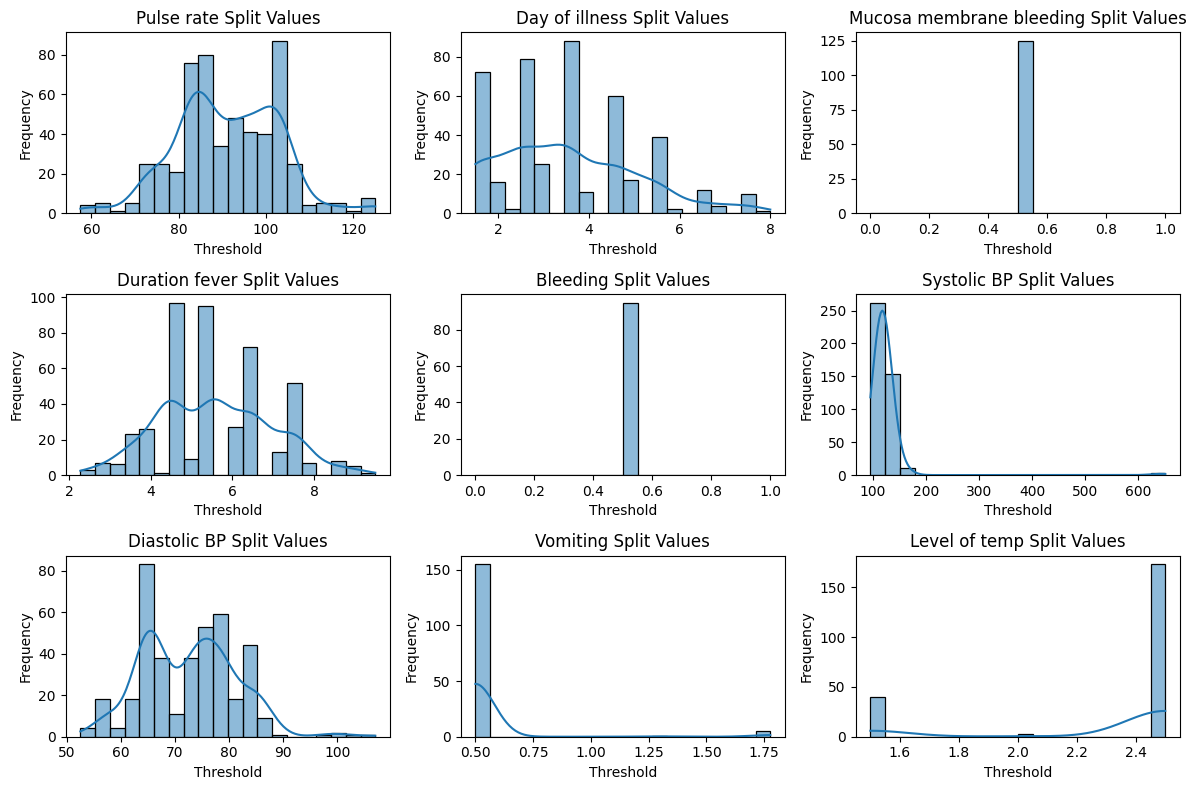

In [ ]:
# Get split values for each feature
split_values = extract_split_values(rf_2, features)


# Sort features by importance
importances = rf_2.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
top_features = [features[i] for i in sorted_idx[:9]]  # Top 5 features

plt.figure(figsize=(12, 8))
for i, feature in enumerate(top_features):
    plt.subplot(3, 3, i+1)
    # plt.hist(split_values[feature], bins=20)
    sns.histplot(split_values[feature], bins=20, kde=True)
    plt.title(f"{feature} Split Values")
    plt.xlabel("Threshold")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [27]:
import shap

explainer = shap.TreeExplainer(rf_2)
shap_values = explainer.shap_values(x2_test)

# Summary plot
# shap.summary_plot(shap_values[1], x2_test, feature_names=features)

# shap.force_plot(explainer.expected_value[1], shap_values[1][2], x2_test[2])